In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import analyze # takes some time since inits hax
from channel_dict import channel_dict
from tqdm import tqdm
import datetime
import pickle
from scipy.stats import norm

%matplotlib inline

# Job Submission

In [ ]:
from make_runlist_new import write_spe_lists

#dry run
write_spe_lists(write=False)

In [ ]:
#writes new runlists
written=write_spe_lists(write=True)
print(written)

### This will take some time to run as job submission takes several hours. Alternatively, in the terminal you can run ./submit_jobs.sh ./runlists/[runlist name] for a single runlist, or ./large_submission.sh to submit jobs for all runlists in ./runlists

In [ ]:
def submit_job(file):
    command = "./submit_jobs.sh %s" % file
    print(command)
    !{command}

In [ ]:
for f in written:
    submit_job(f)

# Acc Vs Time

In [2]:
import hax
#hax already initiated when analyze is imported

from spe_acceptance import data_dir_base


def data_exists(run_number):
    data_path=os.path.join(data_dir_base, 'run_%05d.h5' %run_number)
    return os.path.exists(data_path)

def all_data_exists(runlist):
    return all([data_exists(run) for run in runlist])

def file_to_list(runlist_file):
    return [int(run) for run in runlist_file.split('.')[0].split('_')[1:4]]

def get_run_time(run):
    return hax.runs.datasets[hax.runs.datasets.number == run].start.values[0]

def find_file(run):
    return [f for f in os.listdir('runlists') if str(run) in f]

#### Retrieves previously loaded data from pickle file

In [3]:
#all runlists
runlists = [f for f in os.listdir('./runlists')]
bottom_runs = []
accs = []

ch_acc_dict={}
ch_err_l={}
ch_err_u={}

upper_errs=[]
lower_errs=[]
errors = []

missing_runs = []
LED_off = []
resubmit_files = []

with open('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl', 'rb') as cd:
    if os.stat('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl').st_size==0:
        data=[]
    else:
        data=pickle.load(cd)
saved_runlists=[]

for cd in data:
    if len(data)==0:
        continue
        
    saved_runlists.append(cd.runlist)
    
    acc=cd.acc
    on_acc=cd.on_acc
    acc_errs_l=cd.acc_errs_l
    acc_errs_u=cd.acc_errs_u
    acc_sys=cd.acc_sys
    acc_stat=cd.acc_stat
    occ=cd.occ
    occ_sys=cd.occ_sys
    occ_stat=cd.occ_stat
    
    ch_acc_dict[cd.runlist]=acc
    
    ch_err_l[cd.runlist]=np.mean(acc_errs_l**2, axis=1)
    ch_err_u[cd.runlist]=np.mean(acc_errs_u**2, axis=1)
    
    runlist = file_to_list(cd.runlist)
    
    bottom_run = runlist[0]
    topbulk_run = runlist[1]
    topring_run = runlist[2]
    
    accs.append(np.mean(on_acc))
    lower_errs.append(np.mean(acc_errs_l**2))
    upper_errs.append(np.mean(acc_errs_u**2))
    bottom_runs.append(bottom_run)

#### Calculates acceptance, errors for new runlists

In [4]:
for f in tqdm(sorted(runlists)):
    if f in saved_runlists:
        #print("Data already exists for: ", f)
        continue
        
    else:
        runlist = file_to_list(f)
        if not all_data_exists(runlist):
            resubmit_files.append(f)
            #print('data missing for %s' % f)
            for r in runlist:
                if not data_exists(r):
                    missing_runs.append(r)
            continue
        
    
        bottom_run = runlist[0]
        topbulk_run = runlist[1]
        topring_run = runlist[2]
        
        if bottom_run<6731:
            continue
        
        thresholds = analyze.get_thresholds(analyze.find_regular_run(bottom_run))
        
        acc, acc_errs, acc_sys, acc_stat = analyze.acceptance_3runs(bottom_run, topbulk_run, topring_run, thresholds)
        occ, occ_sys, occ_stat = analyze.occupancy_3runs(bottom_run, topbulk_run, topring_run)
    
        on_channels = np.where(occ > 0.05)[0]
        
        if len(on_channels) < 200:
            LED_off.append(f)
            #print('LED likely OFF for %s' % f)
            continue
        
        on_acc = acc[on_channels]
        
        ch_acc_dict[f]=acc
        
        acc_errs_l = acc_errs[0]
        acc_errs_u = acc_errs[1]
        
        ch_err_l[f]=acc_errs_l
        ch_err_u[f]=acc_errs_u
        
        accs.append(np.mean(on_acc))
        lower_errs.append(np.mean(acc_errs_l**2, axis=0)[0])
        upper_errs.append(np.mean(acc_errs_u**2, axis=0)[0])
        bottom_runs.append(bottom_run)
        
        cd=analyze.ch_data(f, get_run_time(bottom_run), acc, on_acc, acc_errs_l, acc_errs_u, acc_sys, acc_stat, occ, occ_sys, occ_stat)
        data.append(cd)
        
print("Data already exists for: ", saved_runlists)

  0%|          | 0/113 [00:00<?, ?it/s]/home/awalsh272/SPE/SPE/analyze.py:72: RuntimeWarning: invalid value encountered in true_divide
  sigma_corr_noise=corr_noise*np.sqrt( (sigma_corr/corrections)**2 + (sigma_noise/noise)**2)
100%|██████████| 113/113 [01:53<00:00,  1.00s/it]

Data already exists for:  ['runlist_10064_10065_10066.txt', 'runlist_10133_10134_10135.txt', 'runlist_10297_10298_10299.txt', 'runlist_10524_10525_10526.txt', 'runlist_10610_10611_10612.txt', 'runlist_10696_10697_10698.txt', 'runlist_10796_10797_10798.txt', 'runlist_10877_10878_10879.txt', 'runlist_10986_10987_10988.txt', 'runlist_11069_11070_11071.txt', 'runlist_11429_11430_11431.txt', 'runlist_11625_11626_11627.txt', 'runlist_11733_11734_11736.txt', 'runlist_11813_11814_11815.txt', 'runlist_12046_12047_12048.txt', 'runlist_12130_12131_12132.txt', 'runlist_12211_12213_12214.txt', 'runlist_12318_12319_12320.txt', 'runlist_12398_12399_12400.txt', 'runlist_12511_12512_12513.txt', 'runlist_12587_12588_12589.txt', 'runlist_12768_12769_12770.txt', 'runlist_12946_12947_12948.txt', 'runlist_13128_13129_13130.txt', 'runlist_13300_13301_13303.txt', 'runlist_13657_13658_13659.txt', 'runlist_13837_13838_13839.txt', 'runlist_14192_14193_14195.txt', 'runlist_14555_14556_14557.txt', 'runlist_14733_1

#### Resubmits jobs for runs missing data

In [ ]:
for f in resubmit_files:
    if f<6731:
        continue
    submit_job(f)

#### Dumps all data into pickle file, prints runs with LED off and runs with missing data

In [5]:
os.remove('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl')
with open('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl', 'wb') as cd:
    pickle.dump(data, cd)
    
#Delete raw data after processed data is in the pickle file

errors=np.array([lower_errs, upper_errs])
print("These runs are missing data: ", missing_runs)
print("LED likely off for these files: ", LED_off)

These runs are missing data:  [14907, 15087, 15268, 15811, 15812, 15813, 15987, 15988, 15989, 16237, 16238, 16239, 16343, 16344, 16345, 16523, 16524, 16526, 16701, 16702, 16703, 17587, 17588, 17589, 17784, 17862, 17863, 17864, 17939, 17998, 17999, 18000, 4511, 4512, 4513, 4688, 4689, 4848, 4851, 4850, 4956, 4958, 4957, 5949, 5950, 5951, 6052, 6053, 6248, 6249, 6647, 6836, 7100]
LED likely off for these files:  ['runlist_11277_11278_11279.txt', 'runlist_13433_13434_13435.txt', 'runlist_14088_14089_14090.txt']


#### Acceptance dataframe with channels as row index, runlists as column index

In [6]:
acc_df=pd.DataFrame(ch_acc_dict)
channels_df=pd.DataFrame({"channels": [i for i in range(0,248)]})
ch_df=pd.concat([acc_df, channels_df], axis=1)
ch_df.set_index('channels', inplace=True)
ch_df

,runlist_10064_10065_10066.txt,runlist_10133_10134_10135.txt,runlist_10297_10298_10299.txt,runlist_10524_10525_10526.txt,runlist_10610_10611_10612.txt,runlist_10696_10697_10698.txt,runlist_10796_10797_10798.txt,runlist_10877_10878_10879.txt,runlist_10986_10987_10988.txt,runlist_11069_11070_11071.txt,...,runlist_8840_8841_8842.txt,runlist_8921_8922_8923.txt,runlist_9033_9034_9036.txt,runlist_9112_9113_9114.txt,runlist_9217_9218_9219.txt,runlist_9299_9300_9301.txt,runlist_9549_9550_9551.txt,runlist_9604_9605_9606.txt,runlist_9697_9698_9699.txt,runlist_9797_9798_9799.txt
channels,,,,,,,,,,,,,,,,,,,,,
0,0.935934,0.933048,0.948865,0.928161,0.933032,0.941254,0.933194,0.938441,0.925536,0.918222,...,0.950022,0.942126,0.935104,0.944624,0.921981,0.931942,0.953557,0.925946,0.924462,0.975062
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.898585,0.902590,0.882600,0.910731,0.903367,0.918015,0.928568,0.906360,0.866086,0.971065,...,0.923718,0.921874,0.922096,0.920359,0.930164,0.919406,0.936331,0.917233,0.916742,0.949387
4,0.935251,0.931430,0.933743,0.939473,0.930238,0.926277,0.925215,0.926827,0.952267,0.910587,...,0.940850,0.950287,0.950881,0.958801,0.945898,0.952829,0.971910,0.941530,0.940044,0.918109
5,0.893286,0.896895,0.894706,0.909444,0.929588,0.921343,0.904821,0.934273,0.954174,0.996797,...,0.921440,0.958829,0.915417,0.932373,0.897670,0.911586,0.950268,0.825943,0.886214,0.705465
6,0.933109,0.941535,0.973226,0.959592,0.954232,0.930395,0.914990,0.931521,0.972174,0.732764,...,0.936713,0.977811,0.965629,0.967864,1.027510,0.924928,0.996867,0.963324,0.947332,1.000714
7,0.920966,0.925067,0.910008,0.920053,0.911571,0.921255,0.927353,0.923823,0.925880,0.924058,...,0.944497,0.952754,0.946076,0.932385,0.929059,0.949672,0.952848,0.925726,0.934177,0.930193
8,0.936240,0.930363,0.940019,0.937356,0.946239,0.944613,0.944483,0.930145,0.937096,1.007550,...,0.942042,0.956565,0.942439,0.950337,0.942828,0.944940,0.959796,0.954737,0.941421,0.968535


#### Lower, upper errors dataframes with channels as row index, runlist as column index

In [7]:
lerr_df=pd.DataFrame(ch_err_l)
ch_lerr_df=pd.concat([lerr_df, channels_df], axis=1)
ch_lerr_df.set_index('channels', inplace=True)
ch_lerr_df

{'runlist_8627_8628_8629.txt': array([  3.54006134e-03,   2.30479544e-04,   2.99883646e-03,
         2.44471804e-03,   1.73472803e-03,   2.19549477e-03,
         4.11129985e-03,   8.71563567e-04,   1.36967441e-04,
         1.16402032e-03,   1.20791972e-03,   1.37751450e-04,
         5.87636930e-05,   6.04109091e-03,   1.53858678e-03,
         1.86330568e-03,   1.53809050e-02,   1.73547763e-03,
         2.00063519e-03,   9.59131431e-04,   5.92972709e-03,
         5.21114751e-03,   2.10140672e-04,   1.37295780e-03,
         3.90243889e-03,   8.10958697e-03,   3.08556636e-03,
         8.04336331e-03,   1.18847065e-03,   6.87508460e-03,
         1.43261386e-03,   6.73594129e-04,   1.05382563e-02,
         8.49433958e-05,   1.07787939e-03,   7.78615835e-05,
         8.71611029e-03,   2.10171076e-02,   1.14523648e-03,
         2.46590133e-03,   3.63869116e-03,   2.04224785e-03,
         1.11868292e-02,   2.66863678e-03,   8.40680078e-05,
         3.93716907e-04,   1.37048983e-02,   1.0475742

,runlist_10064_10065_10066.txt,runlist_10133_10134_10135.txt,runlist_10297_10298_10299.txt,runlist_10524_10525_10526.txt,runlist_10610_10611_10612.txt,runlist_10696_10697_10698.txt,runlist_10796_10797_10798.txt,runlist_10877_10878_10879.txt,runlist_10986_10987_10988.txt,runlist_11069_11070_11071.txt,...,runlist_8840_8841_8842.txt,runlist_8921_8922_8923.txt,runlist_9033_9034_9036.txt,runlist_9112_9113_9114.txt,runlist_9217_9218_9219.txt,runlist_9299_9300_9301.txt,runlist_9549_9550_9551.txt,runlist_9604_9605_9606.txt,runlist_9697_9698_9699.txt,runlist_9797_9798_9799.txt
channels,,,,,,,,,,,,,,,,,,,,,
0,0.001261,0.001730,0.000384,0.002100,0.001476,0.001129,0.001782,0.001194,0.002643,0.002674,...,0.000523,0.000889,0.001479,0.000709,0.002703,0.001674,0.000541,0.002075,0.002623,0.000634
1,0.002709,0.001392,0.002986,0.000230,0.000096,0.001465,0.003088,0.000467,0.002736,0.000222,...,0.002230,0.002330,0.001586,0.000241,0.001653,0.001766,0.000407,0.000241,0.001261,0.000143
2,0.000170,0.000147,0.002917,0.000065,0.000356,0.002962,0.000133,0.000077,0.000005,0.000012,...,0.000134,0.000638,0.000198,0.000223,0.000074,0.000124,0.002636,0.000015,0.000052,0.000029
3,0.005786,0.005364,0.009565,0.003817,0.005107,0.003381,0.002131,0.004898,0.015473,0.000906,...,0.001815,0.002149,0.002743,0.003107,0.001651,0.002926,0.001128,0.002595,0.003365,0.000595
4,0.002592,0.003392,0.003357,0.002301,0.003420,0.003852,0.004569,0.001150,0.001114,0.005884,...,0.002404,0.000951,0.001400,0.001433,0.003249,0.000930,0.000372,0.001747,0.002156,0.007933
5,0.006813,0.005590,0.005238,0.004197,0.001226,0.003150,0.004861,0.001150,0.000108,0.001566,...,0.002808,0.000107,0.003391,0.001958,0.004909,0.003551,0.000393,0.015966,0.006067,0.028508
6,0.003822,0.001681,0.000314,0.000568,0.001084,0.003265,0.004404,0.003093,0.000206,0.027403,...,0.002035,0.000224,0.000849,0.000384,0.001675,0.003399,0.000203,0.000509,0.001921,0.006165
7,0.003177,0.002644,0.004843,0.003098,0.004774,0.003243,0.002161,0.002556,0.002797,0.002259,...,0.000653,0.000190,0.000399,0.001640,0.001693,0.000234,0.000210,0.002089,0.001341,0.001767
8,0.001064,0.001797,0.000662,0.001365,0.000547,0.000516,0.000367,0.001375,0.000725,0.003770,...,0.000623,0.000206,0.000708,0.000191,0.000571,0.000506,0.000130,0.000476,0.000643,0.000911


In [8]:
uerr_df=pd.DataFrame(ch_err_u)
ch_uerr_df=pd.concat([uerr_df, channels_df], axis=1)
ch_uerr_df.set_index('channels', inplace=True)
ch_uerr_df

,runlist_10064_10065_10066.txt,runlist_10133_10134_10135.txt,runlist_10297_10298_10299.txt,runlist_10524_10525_10526.txt,runlist_10610_10611_10612.txt,runlist_10696_10697_10698.txt,runlist_10796_10797_10798.txt,runlist_10877_10878_10879.txt,runlist_10986_10987_10988.txt,runlist_11069_11070_11071.txt,...,runlist_8840_8841_8842.txt,runlist_8921_8922_8923.txt,runlist_9033_9034_9036.txt,runlist_9112_9113_9114.txt,runlist_9217_9218_9219.txt,runlist_9299_9300_9301.txt,runlist_9549_9550_9551.txt,runlist_9604_9605_9606.txt,runlist_9697_9698_9699.txt,runlist_9797_9798_9799.txt
channels,,,,,,,,,,,,,,,,,,,,,
0,0.001260,0.001729,0.000385,0.002099,0.001475,0.001129,0.001782,0.001195,0.002643,0.002675,...,0.000524,0.000889,0.001480,0.000709,0.002701,0.001674,0.000540,0.002075,0.002622,0.000634
1,0.000781,0.002055,0.000862,0.000323,0.000078,0.001645,0.002089,0.000477,0.001786,0.000281,...,0.001664,0.001143,0.002287,0.000354,0.001919,0.002776,0.000796,0.000201,0.002300,0.000143
2,0.000160,0.000144,0.000959,0.000052,0.000350,0.001412,0.000127,0.000074,0.000006,0.000013,...,0.000181,0.000617,0.000272,0.000390,0.000066,0.000110,0.004048,0.000019,0.000047,0.000024
3,0.005787,0.005363,0.009564,0.003817,0.005107,0.003380,0.002130,0.004898,0.015474,0.000906,...,0.001814,0.002149,0.002742,0.003106,0.001650,0.002927,0.001129,0.002595,0.003365,0.000596
4,0.002591,0.003392,0.003357,0.002301,0.003420,0.003853,0.004570,0.001150,0.001116,0.005883,...,0.002404,0.000951,0.001401,0.001433,0.003249,0.000930,0.000373,0.001747,0.002156,0.007932
5,0.006813,0.005590,0.005238,0.004196,0.001226,0.003149,0.004860,0.001150,0.000108,0.001566,...,0.002808,0.000107,0.003392,0.001958,0.004909,0.003550,0.000393,0.015966,0.006067,0.028508
6,0.003822,0.001681,0.000312,0.000568,0.001083,0.003266,0.004404,0.003093,0.000209,0.027403,...,0.002035,0.000225,0.000846,0.000382,0.001672,0.003398,0.000202,0.000509,0.001919,0.006168
7,0.003176,0.002644,0.004842,0.003098,0.004774,0.003244,0.002159,0.002556,0.002795,0.002258,...,0.000653,0.000190,0.000399,0.001640,0.001693,0.000235,0.000210,0.002089,0.001343,0.001768
8,0.001064,0.001797,0.000665,0.001364,0.000548,0.000514,0.000367,0.001374,0.000726,0.003770,...,0.000623,0.000207,0.000709,0.000193,0.000569,0.000507,0.000130,0.000476,0.000643,0.000910


## Newest Runlist

#### Finds newest runlist, gets acceptance and occupancy 

In [9]:
#finds the newest runlist, gets acc and occ for them
newest_runlist=find_file(sorted(bottom_runs)[-1])
print(newest_runlist)
newest_runs=file_to_list(newest_runlist[0])
bot_run=newest_runs[0]
tb_run=newest_runs[1]
tr_run=newest_runs[2]

#doesn't save the data
thresholds = analyze.get_thresholds(analyze.find_regular_run(bot_run))
acc, acc_errs, acc_sys, acc_stat = analyze.acceptance_3runs(bot_run, tb_run, tr_run, thresholds)
occ, occ_sys, occ_stat = analyze.occupancy_3runs(bot_run, tb_run, tr_run)

on_channels = np.where(occ > 0.05)[0]

acc=acc[on_channels]

['runlist_17454_17455_17456.txt']


/home/awalsh272/SPE/SPE/analyze.py:72: RuntimeWarning: invalid value encountered in true_divide
  sigma_corr_noise=corr_noise*np.sqrt( (sigma_corr/corrections)**2 + (sigma_noise/noise)**2)


#### Channels that look off, 

In [10]:
#prints list of off pmts
my_off = np.where(occ < 0.05)[0]
print("Channels that look off: ", my_off)

Channels that look off:  [  1   2  12  26  34  62  65  79  86  88 102 118 130 134 135 137 139 148
 150 152 162 178 183 190 198 206 213 214 234 239 244]


#### Acceptance histogram for one runlist

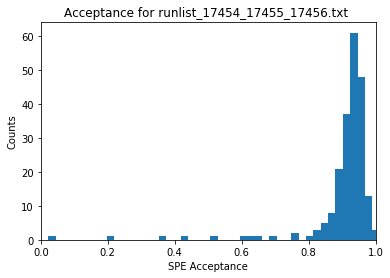

In [11]:
#plot the acceptance of one runlist
plt.hist(acc, bins=50, range=(0,1.1))
plt.title("Acceptance for %s " %newest_runlist[0])
plt.xlabel("SPE Acceptance")
plt.ylabel("Counts")
plt.xlim(0, 1)
plt.show()

#### Occupancy histogram for one runlist

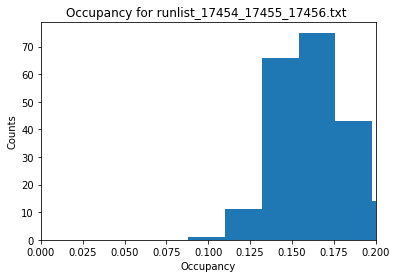

In [12]:
#plot the occupancy of one runlist

occ=occ[on_channels]

plt.hist(occ, bins=50, range=(0,1.1))
plt.title("Occupancy for %s " %newest_runlist[0])
plt.xlabel("Occupancy")
plt.ylabel("Counts")
plt.xlim(0,0.2)
plt.show()

#### Prints low acceptance channels

In [13]:
#prints list of low acc ch
cha_dict_new={}

for ch, a in zip(on_channels, acc):
    cha_dict_new[a]=ch
    
low_acc_ch=[]
for a in acc:
    if a<0.5:
        low_acc_ch.append(cha_dict_new[a])
        
print('Low acc ch: ', low_acc_ch)

Low acc ch:  [27, 31, 73, 203]


#### Mean, Median, Errors for runlist

In [14]:
acc_mean=np.nanmean(ch_acc_dict[newest_runlist[0]])
acc_median=np.nanmedian(ch_acc_dict[newest_runlist[0]])

print("Runlist: ", newest_runlist[0])
print("Mean Acceptance: ", acc_mean)
print("Median Acceptance: ", acc_median)
print("Errors [l,u]: ", [np.nanmean(ch_err_l[newest_runlist[0]]), np.nanmean(ch_err_u[newest_runlist[0]])])

Runlist:  runlist_17454_17455_17456.txt
Mean Acceptance:  0.796159178849
Median Acceptance:  0.929015557385
Errors [l,u]:  [0.0034840747381606843, 0.0034204851388128731]


## Average Acceptance per Runlist

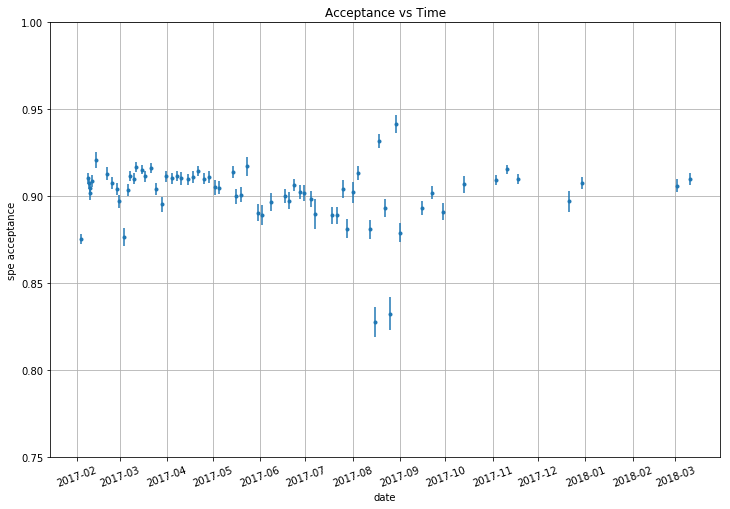

In [15]:
#plot acceptance vs time using full runlists

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%Y-%m')

bottom_runs = np.array(bottom_runs)

dates = np.array([get_run_time(run) for run in bottom_runs])

accs = np.array(accs)
errors = np.array(errors)

noisy_runs = [12768, 13837]

sr1 = np.where(bottom_runs > 6731)
sr1 = [i for i in sr1[0] if bottom_runs[i] not in noisy_runs]

plot_dates = dates[sr1]
plot_runs = bottom_runs[sr1]
plot_accs = accs[sr1]
plot_errors = [errors[0][sr1],errors[1][sr1]]

f, ax = plt.subplots(figsize=(12,8))
#plt.errorbar(bottom_runs, accs, yerr=errors, linestyle='None', marker='.')
ax.errorbar(plot_dates, plot_accs, yerr=plot_errors, linestyle='None', marker='.')
ax.set_ylim(0.75, 1.0)
plt.xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=20)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(fmt)
ax.grid()
ax.set_xlabel('date')
ax.set_ylabel('spe acceptance')

plt.title("Acceptance vs Time")

plt.savefig('new_moneyplot.png')
plt.show()

#### Mean, Median, Errors for all runlists

In [16]:
#add table of mean/median w errors for time evo, print days that are outliers

evo_mean=np.nanmean(plot_accs)
evo_median=np.nanmedian(plot_accs)
evo_errs=[np.nanmean(plot_errors[0]), np.nanmean(plot_errors[1])]

evo_std=np.nanstd(plot_accs)

print("All Runlists")
print("Mean :", evo_mean)
print("Median :", evo_median)
print("Errors [l, u]: ", evo_errs)

All Runlists
Mean : 0.902030734425
Median : 0.904980765945
Errors [l, u]:  [0.0042183787961173986, 0.0041939545027940509]


## Acceptance for Individual Channels

### One Channel

#### Plots acceptances of one channel for all runlists

[10064 10133 10297 10524 10610 10696 10796 10877 10986 11069 11429 11625
 11733 11813 12046 12130 12211 12318 12398 12511 12587 12946 13128 13300
 13657 14192 14555 14733 15420 15625 16984 17249 17454  6753  6892  6909
  6938  6957  6984  7067  7268  7350  7447  7485  7569  7646  7680  7758
  7795  7912  7968  8069  8154  8267  8350  8448  8545  8627  8735  8840
  8921  9033  9112  9217  9299  9549  9604  9697  9797 11352 11535 14369]
72
(72,)
runlist_10064_10065_10066.txt    0.935934
runlist_10133_10134_10135.txt    0.933048
runlist_10297_10298_10299.txt    0.948865
runlist_10524_10525_10526.txt    0.928161
runlist_10610_10611_10612.txt    0.933032
runlist_10696_10697_10698.txt    0.941254
runlist_10796_10797_10798.txt    0.933194
runlist_10877_10878_10879.txt    0.938441
runlist_10986_10987_10988.txt    0.925536
runlist_11069_11070_11071.txt    0.918222
runlist_11429_11430_11431.txt    0.938959
runlist_11625_11626_11627.txt    0.922176
runlist_11733_11734_11736.txt    0.917472
runlis

RuntimeError: xdata and ydata must be the same length

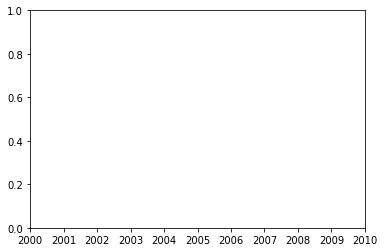

In [50]:
ch=0

sr1_rl=[find_file(i) for i in bottom_runs[s]]
print(len(sr1_rl))
sr1_rl=[runlist for elem in sr1_rl for runlist in elem]

#plt.plot(plot_dates, ch_df.loc[ch,:][sr1], linestyle='None', marker='.')
print(plot_dates.shape)
print(ch_df.loc[ch,sr1_rl])
plt.errorbar(plot_dates, ch_df.loc[ch, sr1_rl] , yerr=[ch_lerr_df.loc[ch, sr1_rl], ch_uerr_df.loc[ch, sr1_rl]], linestyle='None', marker='.')
plt.ylim(0.75, 1.1)
plt.xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=20)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(fmt)
plt.grid()
plt.title("Channel %s" %ch)
plt.xlabel('date')
plt.ylabel('spe acceptance')
#plt.savefig('new_moneyplot.png')
plt.show()

#### Prints runlists with low acceptance for one channel

In [ ]:
#prints list of low acc runlists

ch_accs=np.array(ch_df.loc[0])

low_acc=np.where(ch_accs<0.5)

low_acc_rl=list(ch_df.columns[low_acc])
        
print('Low acc runlists for ch %s: ' %ch, low_acc_rl)

# Further Analysis

### Find outliers, plot the acceptance curve, acceptance histogram, and occupancy histogram

In [ ]:
#Find outliers, plot acc of one of them

outlier_indices_low = np.array(np.where(accs < (evo_mean-2*evo_std))).flatten()
outlier_indices_high= np.array(np.where(accs > (evo_mean+2*evo_std))).flatten()

outlier_indices=outlier_indices_low.tolist() + outlier_indices_high.tolist()

outliers = bottom_runs[outlier_indices]
print("Outliers :", outliers)
run = outliers[0] #change index to change which outlier
print('Run: ',run)
runlist = file_to_list(find_file(run)[0])

bot_run=runlist[0]
tb_run=runlist[1]
tr_run=runlist[2]

x, acc, err = analyze.acceptance_curve_3runs(bot_run, tb_run, tr_run)

plt.figure(figsize=(9,6))
for ch, a in enumerate(acc):
    plt.plot(x, a, color='black', linewidth=1, alpha=0.6)
    plt.title("Acceptance curve for: %d" %run)
    
plt.xlim(-10, 200)
plt.xlabel('threshold')
plt.ylabel('spe acceptance')
plt.show()

In [ ]:
#doesn't save the data
thresholds = analyze.get_thresholds(analyze.find_regular_run(bot_run))
acc, acc_errs, acc_sys, acc_stat = analyze.acceptance_3runs(bot_run, tb_run, tr_run, thresholds)
occ, occ_sys, occ_stat = analyze.occupancy_3runs(bot_run, tb_run, tr_run)

on_channels = np.where(occ > 0.05)[0]

acc=acc[on_channels]
occ=occ[on_channels]

In [ ]:
#plot the occupancy of one runlist
plt.hist(occ, bins=50, range=(0,1.1))
plt.title("Occupancy for %s " %find_file(run)[0])
plt.xlabel("Occupancy")
plt.ylabel("Counts")
plt.xlim(0,0.2)
plt.show()

In [ ]:
#plot the acceptance of one runlist
plt.hist(acc, bins=50, range=(0,1.1))
plt.title("Acceptance for %s " %find_file(run)[0])
plt.xlabel("SPE Acceptance")
plt.ylabel("Counts")
plt.xlim(0, 1)
plt.show()

In [ ]:
runlist= find_file(run)[0]

#plot acceptance of each channel
plt.figure()
plt.plot(on_channels, acc, marker='.', linestyle='none')
plt.ylabel('Acceptance Fraction')
plt.xlabel('Channel #')
plt.title('Acc by Ch for %s' %runlist)
plt.show()

In [ ]:
cha_dict={}

for ch, a in zip(on_channels, acc):
    cha_dict[a]=ch
    
low_acc_ch=[]
for a in acc:
    if a<0.5:
        low_acc_ch.append(cha_dict[a])
        
print('Low acc ch: ', low_acc_ch)